In [1]:
import numpy as np
import pandas as pd
import os
import pydicom
import cv2
import matplotlib.pyplot as plt

In [2]:
train  = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
label = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_desc = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')
test_desc = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_series_descriptions.csv')

In [3]:
# Preview the data
train.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [4]:
train_desc.head()

,study_id,series_id,series_description
0,4003253,702807833,Sagittal T2/STIR
1,4003253,1054713880,Sagittal T1
2,4003253,2448190387,Axial T2
3,4646740,3201256954,Axial T2
4,4646740,3486248476,Sagittal T1


In [5]:
train.isnull().sum()

study_id                                    0
spinal_canal_stenosis_l1_l2                 1
spinal_canal_stenosis_l2_l3                 1
spinal_canal_stenosis_l3_l4                 1
spinal_canal_stenosis_l4_l5                 1
spinal_canal_stenosis_l5_s1                 1
left_neural_foraminal_narrowing_l1_l2       2
left_neural_foraminal_narrowing_l2_l3       2
left_neural_foraminal_narrowing_l3_l4       2
left_neural_foraminal_narrowing_l4_l5       2
left_neural_foraminal_narrowing_l5_s1       2
right_neural_foraminal_narrowing_l1_l2      8
right_neural_foraminal_narrowing_l2_l3      8
right_neural_foraminal_narrowing_l3_l4      8
right_neural_foraminal_narrowing_l4_l5      8
right_neural_foraminal_narrowing_l5_s1      8
left_subarticular_stenosis_l1_l2          164
left_subarticular_stenosis_l2_l3           82
left_subarticular_stenosis_l3_l4            3
left_subarticular_stenosis_l4_l5            3
left_subarticular_stenosis_l5_s1           11
right_subarticular_stenosis_l1_l2 

In [6]:
# Function to generate image paths based on directory structure
def generate_image_paths(df, data_dir):
    image_paths = []
    for study_id, series_id in zip(df['study_id'], df['series_id']):
        study_dir = os.path.join(data_dir, str(study_id))
        series_dir = os.path.join(study_dir, str(series_id))
        images = os.listdir(series_dir)
        image_paths.extend([os.path.join(series_dir, img) for img in images])
    return image_paths

# Generate image paths for train and test data
train_image_paths = generate_image_paths(train_desc, '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
test_image_paths = generate_image_paths(test_desc, '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images')

In [7]:
def reshape_dataframe(df):
    # Create a list of columns to exclude
    exclude_columns = ['study_id', 'series_id', 'instance_number', 'x', 'y', 'series_description']
    
    # Filter the columns to process
    columns_to_process = [col for col in df.columns if col not in exclude_columns]
    
    # Split the columns into condition and level, extract severity, and concatenate to form the new DataFrame
    reshaped_df = pd.DataFrame([
        {
            'study_id': row['study_id'],
            'condition': ' '.join([word.capitalize() for word in col.split('_')[:-2]]),
            'level': col.split('_')[-2].capitalize() + '/' + col.split('_')[-1].capitalize(),
            'severity': row[col]
        }
        for _, row in df.iterrows()
        for col in columns_to_process
    ])
    
    return reshaped_df

# Reshape the DataFrame
new_train_df = reshape_dataframe(train)

# Display the first few rows of the reshaped DataFrame
new_train_df.head()

,study_id,condition,level,severity
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild


In [8]:
# Print columns in a neat way
print("\nColumns in new_train_df:")
print(",".join(new_train_df.columns))

print("\nColumns in label:")
print(",".join(label.columns))

print("\nColumns in test_desc:")
print(",".join(test_desc.columns))


Columns in new_train_df:
study_id,condition,level,severity

Columns in label:
study_id,series_id,instance_number,condition,level,x,y

Columns in test_desc:
study_id,series_id,series_description


In [9]:
# Merge the dataframes on the common columns
merged_df = pd.merge(new_train_df, label, on=['study_id', 'condition', 'level'], how='inner')
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on='series_id', how='inner')

In [10]:
# Merge the dataframes on the common column 'series_id'
final_merged_df = pd.merge(merged_df, train_desc, on=['series_id','study_id'], how='inner')
# Display the first few rows of the final merged dataframe
final_merged_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR


In [11]:
final_merged_df[final_merged_df['study_id'] == 4003253].sort_values(['x','y'],ascending = True)

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
22,4003253,Right Subarticular Stenosis,L3/L4,Normal/Mild,2448190387,19,142.843690,156.179561,Axial T2
20,4003253,Right Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,4,145.288771,158.624642,Axial T2
21,4003253,Right Subarticular Stenosis,L2/L3,Normal/Mild,2448190387,11,145.900042,157.096466,Axial T2
24,4003253,Right Subarticular Stenosis,L5/S1,Normal/Mild,2448190387,35,145.900042,161.375358,Axial T2
23,4003253,Right Subarticular Stenosis,L4/L5,Normal/Mild,2448190387,28,147.428218,158.013372,Axial T2
18,4003253,Left Subarticular Stenosis,L4/L5,Moderate,2448190387,28,172.948842,156.911197,Axial T2
17,4003253,Left Subarticular Stenosis,L3/L4,Normal/Mild,2448190387,19,176.037645,157.528958,Axial T2
15,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2
19,4003253,Left Subarticular Stenosis,L5/S1,Normal/Mild,2448190387,35,179.744208,161.853282,Axial T2
16,4003253,Left Subarticular Stenosis,L2/L3,Normal/Mild,2448190387,11,180.979730,158.764479,Axial T2


In [12]:
final_merged_df[final_merged_df['series_id'] == 2448190387].sort_values("instance_number")

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
15,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2
20,4003253,Right Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,4,145.288771,158.624642,Axial T2
21,4003253,Right Subarticular Stenosis,L2/L3,Normal/Mild,2448190387,11,145.900042,157.096466,Axial T2
16,4003253,Left Subarticular Stenosis,L2/L3,Normal/Mild,2448190387,11,180.979730,158.764479,Axial T2
22,4003253,Right Subarticular Stenosis,L3/L4,Normal/Mild,2448190387,19,142.843690,156.179561,Axial T2
17,4003253,Left Subarticular Stenosis,L3/L4,Normal/Mild,2448190387,19,176.037645,157.528958,Axial T2
18,4003253,Left Subarticular Stenosis,L4/L5,Moderate,2448190387,28,172.948842,156.911197,Axial T2
23,4003253,Right Subarticular Stenosis,L4/L5,Normal/Mild,2448190387,28,147.428218,158.013372,Axial T2
19,4003253,Left Subarticular Stenosis,L5/S1,Normal/Mild,2448190387,35,179.744208,161.853282,Axial T2
24,4003253,Right Subarticular Stenosis,L5/S1,Normal/Mild,2448190387,35,145.900042,161.375358,Axial T2


In [13]:
# Filter the dataframe for the given study_id and sort by instance_number
filtered_df = final_merged_df[final_merged_df['study_id'] == 4003253].sort_values("instance_number")

# Display the resulting dataframe
filtered_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
15,4003253,Left Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,3,179.126448,161.235521,Axial T2
13,4003253,Right Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,4,187.961759,251.839388,Sagittal T1
14,4003253,Right Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,4,198.240918,285.613767,Sagittal T1
20,4003253,Right Subarticular Stenosis,L1/L2,Normal/Mild,2448190387,4,145.288771,158.624642,Axial T2
12,4003253,Right Neural Foraminal Narrowing,L3/L4,Moderate,1054713880,5,187.227533,210.722753,Sagittal T1
11,4003253,Right Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,6,191.632887,165.934990,Sagittal T1
10,4003253,Right Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,6,194.569790,127.755258,Sagittal T1
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR


In [14]:
# Sort final_merged_df by study_id, series_id, and series_description
sorted_final_merged_df = final_merged_df[final_merged_df['study_id'] == 4003253].sort_values(by=['series_id', 'series_description', 'instance_number'])
sorted_final_merged_df

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR
13,4003253,Right Neural Foraminal Narrowing,L4/L5,Moderate,1054713880,4,187.961759,251.839388,Sagittal T1
14,4003253,Right Neural Foraminal Narrowing,L5/S1,Normal/Mild,1054713880,4,198.240918,285.613767,Sagittal T1
12,4003253,Right Neural Foraminal Narrowing,L3/L4,Moderate,1054713880,5,187.227533,210.722753,Sagittal T1
10,4003253,Right Neural Foraminal Narrowing,L1/L2,Normal/Mild,1054713880,6,194.569790,127.755258,Sagittal T1
11,4003253,Right Neural Foraminal Narrowing,L2/L3,Normal/Mild,1054713880,6,191.632887,165.934990,Sagittal T1


In medical imaging for spinal conditions, specific MRI sequences are often used to identify different types of spinal stenosis:

- **Sagittal T1-weighted images** are primarily utilized to evaluate **Neural Foraminal Narrowing**. 
- **Axial T2-weighted images** are crucial for assessing **Subarticular Stenosis**. 
- **Sagittal T2-weighted or STIR (Short Tau Inversion Recovery) images** are typically employed to detect and analyze **Spinal Canal Stenosis**.

These imaging sequences are chosen for their ability to provide the most relevant anatomical and pathological information for each specific type of stenosis.

In [15]:
# Create the row_id column
final_merged_df['row_id'] = (
    final_merged_df['study_id'].astype(str) + '_' +
    final_merged_df['condition'].str.lower().str.replace(' ', '_') + '_' +
    final_merged_df['level'].str.lower().str.replace('/', '_')
)

# Create the image_path column
final_merged_df['image_path'] = (
    '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/' + 
    final_merged_df['study_id'].astype(str) + '/' +
    final_merged_df['series_id'].astype(str) + '/' +
    final_merged_df['instance_number'].astype(str) + '.dcm'
)

# Note: Check image path, since there's 1 instance id, for 1 image, but there's many more images other than the ones labelled in the instance ID. 

# Display the updated dataframe
final_merged_df.head()

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


In [16]:
final_merged_df[final_merged_df["severity"] == "Normal/Mild"].value_counts().sum()
final_merged_df[final_merged_df["severity"] == "Moderate"].value_counts().sum()

7950

In [17]:
# Define the base path for test images
base_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images'

# Function to get image paths for a series
def get_image_paths(row):
    series_path = os.path.join(base_path, str(row['study_id']), str(row['series_id']))
    if os.path.exists(series_path):
        return [os.path.join(series_path, f) for f in os.listdir(series_path) if os.path.isfile(os.path.join(series_path, f))]
    return []

# Mapping of series_description to conditions
condition_mapping = {
    'Sagittal T1': {'left': 'left_neural_foraminal_narrowing', 'right': 'right_neural_foraminal_narrowing'},
    'Axial T2': {'left': 'left_subarticular_stenosis', 'right': 'right_subarticular_stenosis'},
    'Sagittal T2/STIR': 'spinal_canal_stenosis'
}

# Create a list to store the expanded rows
expanded_rows = []

# Expand the dataframe by adding new rows for each file path
for index, row in test_desc.iterrows():
    image_paths = get_image_paths(row)
    conditions = condition_mapping.get(row['series_description'], {})
    if isinstance(conditions, str):  # Single condition
        conditions = {'left': conditions, 'right': conditions}
    for side, condition in conditions.items():
        for image_path in image_paths:
            expanded_rows.append({
                'study_id': row['study_id'],
                'series_id': row['series_id'],
                'series_description': row['series_description'],
                'image_path': image_path,
                'condition': condition,
                'row_id': f"{row['study_id']}_{condition}"
            })

# Create a new dataframe from the expanded rows
expanded_test_desc = pd.DataFrame(expanded_rows)

# Display the resulting dataframe
expanded_test_desc.head(5)

,study_id,series_id,series_description,image_path,condition,row_id
0,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
1,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
2,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
3,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing
4,44036939,2828203845,Sagittal T1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...,left_neural_foraminal_narrowing,44036939_left_neural_foraminal_narrowing


In [18]:
final_merged_df['severity'] = final_merged_df['severity'].fillna('Normal/Mild')

In [19]:
test_data = expanded_test_desc
train_data = final_merged_df

In [20]:
train_data.isnull().sum()

study_id              0
condition             0
level                 0
severity              0
series_id             0
instance_number       0
x                     0
y                     0
series_description    0
row_id                0
image_path            0
dtype: int64

In [21]:
train_data

,study_id,condition,level,severity,series_id,instance_number,x,y,series_description,row_id,image_path
0,4003253,Spinal Canal Stenosis,L1/L2,Normal/Mild,702807833,8,322.831858,227.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
1,4003253,Spinal Canal Stenosis,L2/L3,Normal/Mild,702807833,8,320.571429,295.714286,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
2,4003253,Spinal Canal Stenosis,L3/L4,Normal/Mild,702807833,8,323.030303,371.818182,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
3,4003253,Spinal Canal Stenosis,L4/L5,Normal/Mild,702807833,8,335.292035,427.327434,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
4,4003253,Spinal Canal Stenosis,L5/S1,Normal/Mild,702807833,8,353.415929,483.964602,Sagittal T2/STIR,4003253_spinal_canal_stenosis_l5_s1,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
...,...,...,...,...,...,...,...,...,...,...,...
48687,4290709089,Right Subarticular Stenosis,L1/L2,Normal/Mild,3390218084,2,307.180844,354.869960,Axial T2,4290709089_right_subarticular_stenosis_l1_l2,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48688,4290709089,Right Subarticular Stenosis,L2/L3,Normal/Mild,3390218084,6,301.440933,362.044847,Axial T2,4290709089_right_subarticular_stenosis_l2_l3,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48689,4290709089,Right Subarticular Stenosis,L3/L4,Normal/Mild,3390218084,10,302.875911,356.304937,Axial T2,4290709089_right_subarticular_stenosis_l3_l4,/kaggle/input/rsna-2024-lumbar-spine-degenerat...
48690,4290709089,Right Subarticular Stenosis,L4/L5,Normal/Mild,3390218084,15,305.745866,340.520184,Axial T2,4290709089_right_subarticular_stenosis_l4_l5,/kaggle/input/rsna-2024-lumbar-spine-degenerat...


## SMOTE

In [22]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

# Mapping for the 'level' column
level_mapping = {'L1/L2': 0, 'L2/L3': 1, 'L3/L4': 2, 'L4/L5': 3, 'L5/S1': 4}
final_merged_df['level_encoded'] = final_merged_df['level'].map(level_mapping)

# Mapping for the 'series_description' column
series_description_mapping = {'Sagittal T1': 0, 'Sagittal T2/STIR': 1, 'Axial T2': 2}
final_merged_df['series_description_encoded'] = final_merged_df['series_description'].map(series_description_mapping)

# Convert categorical features to numerical using LabelEncoder for 'condition' and 'severity'
le_condition = LabelEncoder()
le_severity = LabelEncoder()

final_merged_df['condition_encoded'] = le_condition.fit_transform(final_merged_df['condition'])
final_merged_df['severity_encoded'] = le_severity.fit_transform(final_merged_df['severity'])

# Concatenate condition and severity labels
final_merged_df['combined_label'] = final_merged_df['condition_encoded'].astype(str) + "_" + final_merged_df['severity_encoded'].astype(str)

# Remove non-numeric columns and use only relevant features
X = final_merged_df.drop(['condition', 'severity', 'row_id', 'image_path', 'level', 'series_description', 'condition_encoded', 'severity_encoded', 'combined_label'], axis=1)
X['level'] = final_merged_df['level_encoded']  # Add the newly encoded 'level' column
X['series_description'] = final_merged_df['series_description_encoded']  # Add the newly encoded 'series_description' column

# SMOTE: Apply SMOTE to the concatenated labels (condition + severity)
y_combined = final_merged_df['combined_label']

smote = SMOTE(random_state=42)
X_smote, y_combined_smote = smote.fit_resample(X, y_combined)

# Split back the combined label into separate condition and severity labels
y_condition_smote = y_combined_smote.str.split("_", expand=True)[0].astype(int)  # Condition part
y_severity_smote = y_combined_smote.str.split("_", expand=True)[1].astype(int)  # Severity part

# One-hot encode the target labels for multi-class classification
onehot = OneHotEncoder()

y_condition_smote_oh = onehot.fit_transform(y_condition_smote.values.reshape(-1, 1)).toarray()
y_severity_smote_oh = onehot.fit_transform(y_severity_smote.values.reshape(-1, 1)).toarray()

# Print the shapes to verify correctness
print(f"Shape of X_smote: {X_smote.shape}")
print(f"Shape of y_condition_smote_oh: {y_condition_smote_oh.shape}")
print(f"Shape of y_severity_smote_oh: {y_severity_smote_oh.shape}")

Shape of X_smote: (128280, 9)
Shape of y_condition_smote_oh: (128280, 5)
Shape of y_severity_smote_oh: (128280, 3)


In [23]:
import pandas as pd

# Step 1: Retain 'study_id', 'series_id', 'instance_number', 'x', 'y', and 'level' from the original dataset
X_combined = final_merged_df[['study_id', 'series_id', 'instance_number', 'x', 'y', 'level']].copy()

# Mapping for the 'level' column as specified
level_mapping = {'L1/L2': 1, 'L2/L3': 2, 'L3/L4': 3, 'L4/L5': 4, 'L5/S1': 5}
X_combined['level'] = X_combined['level'].map(level_mapping)

# Step 2: Initialize y_condition_smote_df and apply condition mapping as specified
condition_mapping = {
    'Spinal Canal Stenosis': 1,
    'Left Neural Foraminal Narrowing': 2,
    'Right Neural Foraminal Narrowing': 3,
    'Left Subarticular Stenosis': 4,
    'Right Subarticular Stenosis': 5
}

# Assuming y_condition_smote_oh is available from SMOTE
y_condition_smote_df = pd.DataFrame(y_condition_smote_oh, columns=[f"condition_{i}" for i in range(y_condition_smote_oh.shape[1])])

# Apply the condition mapping
y_condition_smote_df = y_condition_smote_df.replace(condition_mapping)

# Step 3: Initialize y_severity_smote_df from SMOTE results
# Assuming y_severity_smote_oh is available from SMOTE
y_severity_smote_df = pd.DataFrame(y_severity_smote_oh, columns=[f"severity_{i}" for i in range(y_severity_smote_oh.shape[1])])

# Step 4: Convert the integer-related columns in X_combined to actual integers
X_combined['study_id'] = X_combined['study_id'].astype(int)
X_combined['series_id'] = X_combined['series_id'].astype(int)
X_combined['instance_number'] = X_combined['instance_number'].astype(int)
X_combined['level'] = X_combined['level'].astype(int)

# Keep 'x' and 'y' as float
X_combined['x'] = X_combined['x'].astype(float)
X_combined['y'] = X_combined['y'].astype(float)

# Step 5: Initialize X_smote_df from SMOTE result
X_smote_df = pd.DataFrame(X_smote, columns=[f"feature_{i}" for i in range(X_smote.shape[1])])

# Step 6: Drop columns 'feature_0' to 'feature_8'
X_smote_df.drop(columns=[f"feature_{i}" for i in range(9)], inplace=True)

# Step 7: Combine SMOTE features with 'study_id', 'series_id', 'instance_number', 'x', 'y', and 'level'
X_smote_combined_df = pd.concat([X_combined, X_smote_df], axis=1)

# Step 8: Drop rows where all values are NaN/null
X_smote_combined_df.dropna(how='all', inplace=True)

# Step 9: Prevent scientific notation for integer columns and save as CSV
pd.set_option('display.float_format', '{:.0f}'.format)  # Disable scientific notation for integers

In [24]:
X_smote_combined_df

,study_id,series_id,instance_number,x,y,level
0,4003253,702807833,8,323,228,1
1,4003253,702807833,8,321,296,2
2,4003253,702807833,8,323,372,3
3,4003253,702807833,8,335,427,4
4,4003253,702807833,8,353,484,5
...,...,...,...,...,...,...
48687,4290709089,3390218084,2,307,355,1
48688,4290709089,3390218084,6,301,362,2
48689,4290709089,3390218084,10,303,356,3
48690,4290709089,3390218084,15,306,341,4


In [25]:
y_condition_smote_df

,condition_0,condition_1,condition_2,condition_3,condition_4
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
128275,0,0,0,0,1
128276,0,0,0,0,1
128277,0,0,0,0,1
128278,0,0,0,0,1


In [26]:
y_severity_smote_df

,severity_0,severity_1,severity_2
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
128275,0,0,1
128276,0,0,1
128277,0,0,1
128278,0,0,1


In [27]:
# Check the number of samples
print(f"Filtered X_smote_combined_df size: {len(X_smote_combined_df)}")  # Should be 48,692

# Ensure the labels are of the same size as X_smote_combined_df by filtering the corresponding labels
# Make sure this aligns with how rows were dropped earlier in X_smote_combined_df
y_condition_smote_df_filtered = y_condition_smote_df.iloc[:len(X_smote_combined_df)]
y_severity_smote_df_filtered = y_severity_smote_df.iloc[:len(X_smote_combined_df)]

# Now check the sizes
print(f"y_condition_smote_df size after filtering: {len(y_condition_smote_df_filtered)}")  # Should match 48,692
print(f"y_severity_smote_df size after filtering: {len(y_severity_smote_df_filtered)}")    # Should match 48,692

Filtered X_smote_combined_df size: 48692
y_condition_smote_df size after filtering: 48692
y_severity_smote_df size after filtering: 48692


In [28]:
# Save the combined DataFrame and labels to CSV files
X_smote_combined_df.to_csv('/kaggle/working/X_smote_combined.csv', index=False)
y_condition_smote_df.to_csv('/kaggle/working/y_condition_smote_oh.csv', index=False)
y_severity_smote_df.to_csv('/kaggle/working/y_severity_smote_oh.csv', index=False)

# Confirm the export
print("/kaggle/working/X_smote_combined.csv, /kaggle/working/y_condition_smote_oh.csv, /kaggle/working/y_severity_smote_oh.csv exported successfully")

/kaggle/working/X_smote_combined.csv, /kaggle/working/y_condition_smote_oh.csv, /kaggle/working/y_severity_smote_oh.csv exported successfully


In [29]:
# Export the DataFrame to a CSV file
final_merged_df.to_csv('train_processed.csv', index=False)
test_data.to_csv('test_processed.csv', index=False)

In [30]:
import os
import pydicom
import cv2
import numpy as np
from tensorflow.keras.utils import Sequence

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, df, image_folder, y_condition, y_severity, batch_size=32, img_size=(224, 224)):
        self.df = df
        self.image_folder = image_folder
        self.y_condition = y_condition
        self.y_severity = y_severity
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(df))
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get the batch data
        batch_df = self.df.iloc[batch_indices]
        batch_y_condition = self.y_condition[batch_indices]
        batch_y_severity = self.y_severity[batch_indices]
        
        # Load the images for the batch
        images = []
        for _, row in batch_df.iterrows():
            study_id = int(row['study_id'])  # Ensure integer format
            series_id = int(row['series_id'])  # Ensure integer format
            instance_number = int(row['instance_number'])  # Ensure integer format
            
            # Construct image path using integer values (convert to string)
            img_path = os.path.join(self.image_folder, str(study_id), str(series_id), f"{instance_number}.dcm")
            
            # Load and preprocess the DICOM image
            img = self.load_dicom_image(img_path)
            images.append(img)
        
        return np.array(images), {'condition_output': batch_y_condition, 'severity_output': batch_y_severity}
    
    def load_dicom_image(self, image_path):
        try:
            dicom = pydicom.dcmread(image_path)
            if hasattr(dicom, 'pixel_array'):
                img = dicom.pixel_array
                img = cv2.resize(img, self.img_size)  # Resize to 224x224
                img = np.stack((img,) * 3, axis=-1)  # Convert to RGB (3 channels)
                img = img / 255.0  # Normalize
                return img
            else:
                print(f"Warning: No pixel data in DICOM file: {image_path}")
                return np.zeros((*self.img_size, 3))  # Return a blank image if no pixel data
        except Exception as e:
            print(f"Error reading DICOM file: {image_path}. Error: {e}")
            return np.zeros((*self.img_size, 3))  # Return a blank image if any error occurs

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model

# Function to build the ResNet50 model
def build_resnet50_model(num_classes_condition, num_classes_severity, input_shape=(224, 224, 3)):
    inputs = Input(shape=input_shape)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Add global pooling and dense layers for both condition and severity
    x = Flatten()(base_model.output)
    
    # Output for condition classification
    condition_output = Dense(num_classes_condition, activation='softmax', name='condition_output')(x)
    
    # Output for severity classification
    severity_output = Dense(num_classes_severity, activation='softmax', name='severity_output')(x)
    
    # Define the model
    model = Model(inputs, outputs=[condition_output, severity_output])
    
    # Compile the model
    model.compile(optimizer='adam',
                  loss={'condition_output': 'categorical_crossentropy', 'severity_output': 'categorical_crossentropy'},
                  metrics={'condition_output': 'accuracy', 'severity_output': 'accuracy'})
    
    return model

In [32]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

X_train_df, X_val_df, y_train_condition, y_val_condition, y_train_severity, y_val_severity = train_test_split(
    X_smote_combined_df, 
    y_condition_smote_df_filtered.values, 
    y_severity_smote_df_filtered.values, 
    test_size=0.2, 
    random_state=42
)

# Confirm that the split has worked correctly
print(f"X_train_df size: {len(X_train_df)}, X_val_df size: {len(X_val_df)}")
print(f"y_train_condition size: {len(y_train_condition)}, y_val_condition size: {len(y_val_condition)}")
print(f"y_train_severity size: {len(y_train_severity)}, y_val_severity size: {len(y_val_severity)}")

# Callbacks: Early stopping and model checkpointing
earlystop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('resnet50_model.keras', save_best_only=True)

# Define the image folder
image_folder = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/'

# Create data generators for training and validation
train_generator = DataGenerator(X_train_df, image_folder, y_train_condition, y_train_severity, batch_size=32)
val_generator = DataGenerator(X_val_df, image_folder, y_val_condition, y_val_severity, batch_size=32)

# Build the model (adjust num_classes_condition and num_classes_severity as needed)
model = build_resnet50_model(num_classes_condition=5, num_classes_severity=3)

# Train the model with the data generators
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # Set your number of epochs
    callbacks=[earlystop, checkpoint],
    verbose=2
)

X_train_df size: 38953, X_val_df size: 9739
y_train_condition size: 38953, y_val_condition size: 9739
y_train_severity size: 38953, y_val_severity size: 9739
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727176973.353828     277 service.cc:145] XLA service 0x7856e0002eb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727176973.353873     277 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727176998.773239     277 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_23', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1727176998.819376     277 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the

1218/1218 - 1062s - 872ms/step - condition_output_accuracy: 0.6592 - loss: 1.6670 - severity_output_accuracy: 0.7621 - val_condition_output_accuracy: 0.7420 - val_loss: 1.3040 - val_severity_output_accuracy: 0.7599
Epoch 2/10
1218/1218 - 834s - 685ms/step - condition_output_accuracy: 0.7758 - loss: 0.8822 - severity_output_accuracy: 0.7912 - val_condition_output_accuracy: 0.7841 - val_loss: 0.8826 - val_severity_output_accuracy: 0.7878
Epoch 3/10
1218/1218 - 812s - 667ms/step - condition_output_accuracy: 0.7850 - loss: 0.8219 - severity_output_accuracy: 0.8006 - val_condition_output_accuracy: 0.7860 - val_loss: 0.8935 - val_severity_output_accuracy: 0.7958
Epoch 4/10
1218/1218 - 880s - 723ms/step - condition_output_accuracy: 0.7910 - loss: 0.7944 - severity_output_accuracy: 0.8047 - val_condition_output_accuracy: 0.7288 - val_loss: 13.5567 - val_severity_output_accuracy: 0.1630
Epoch 5/10
1218/1218 - 831s - 682ms/step - condition_output_accuracy: 0.7914 - loss: 0.7855 - severity_output

In [38]:
# Save the trained model to the output directory
output_directory = '/kaggle/working/'  # Output folder in Kaggle
model_save_path = os.path.join(output_directory, 'resnet50_model.keras')

# Save the model
model.save(model_save_path)

print(f"Model saved at {model_save_path}")

Model saved at /kaggle/working/resnet50_model.keras


In [39]:
# Define batch size
batch_size = 32  # Set your desired batch size here

# Evaluate the model on validation data
val_generator = DataGenerator(X_val_df, image_folder, y_val_condition, y_val_severity, batch_size=batch_size)

# Perform evaluation, expecting 3 values: overall loss, condition accuracy, severity accuracy
val_loss, val_condition_acc, val_severity_acc = model.evaluate(val_generator)

# Print the evaluation results
print(f"Validation Loss: {val_loss}")
print(f"Validation Condition Accuracy: {val_condition_acc}")
print(f"Validation Severity Accuracy: {val_severity_acc}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


305/305 ━━━━━━━━━━━━━━━━━━━━ 166s 544ms/step - condition_output_accuracy: 0.7872 - loss: 0.8811 - severity_output_accuracy: 0.7854
Validation Loss: 0.8825788497924805
Validation Condition Accuracy: 0.7840640544891357
Validation Severity Accuracy: 0.7877605557441711


305/305 ━━━━━━━━━━━━━━━━━━━━ 163s 535ms/step


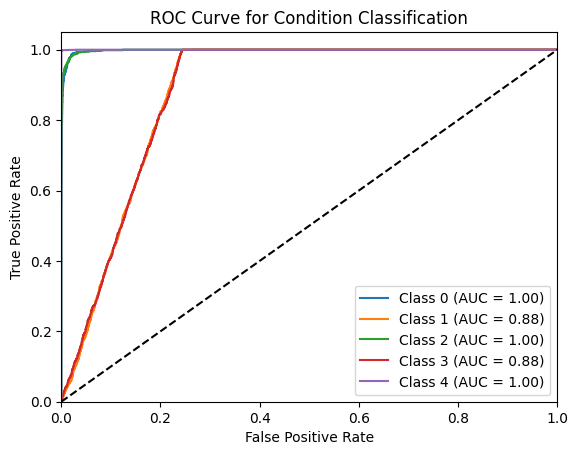

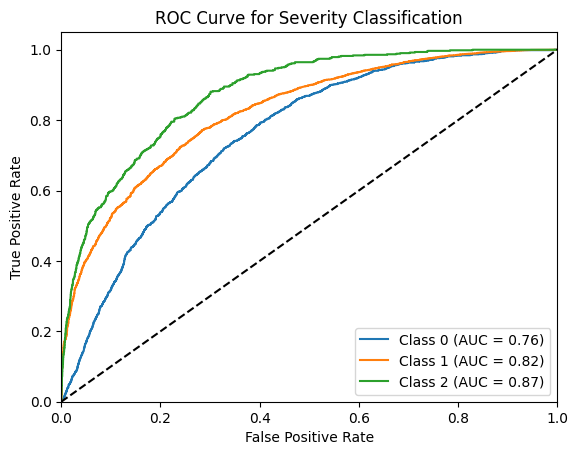

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred, n_classes, title):
    # Binarize the true labels for ROC
    y_true_binarized = label_binarize(y_true, classes=range(n_classes))

    # Compute ROC curve and AUC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Get the model predictions using the validation data generator
y_pred_condition, y_pred_severity = model.predict(val_generator)

# Plot ROC curves for condition classification
plot_roc_curve(y_val_condition.argmax(axis=1), y_pred_condition, 5, "ROC Curve for Condition Classification")

# Plot ROC curves for severity classification
plot_roc_curve(y_val_severity.argmax(axis=1), y_pred_severity, 3, "ROC Curve for Severity Classification")

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Convert predictions to class labels
y_pred_condition_classes = y_pred_condition.argmax(axis=1)
y_pred_severity_classes = y_pred_severity.argmax(axis=1)

y_val_condition_classes = y_val_condition.argmax(axis=1)
y_val_severity_classes = y_val_severity.argmax(axis=1)

# Confusion Matrix for Condition Classification
condition_cm = confusion_matrix(y_val_condition_classes, y_pred_condition_classes)
print("Confusion Matrix for Condition Classification:")
print(condition_cm)

# Confusion Matrix for Severity Classification
severity_cm = confusion_matrix(y_val_severity_classes, y_pred_severity_classes)
print("Confusion Matrix for Severity Classification:")
print(severity_cm)

# Classification Report for Condition Classification
condition_report = classification_report(y_val_condition_classes, y_pred_condition_classes)
print("Classification Report for Condition Classification:")
print(condition_report)

# Classification Report for Severity Classification
severity_report = classification_report(y_val_severity_classes, y_pred_severity_classes)
print("Classification Report for Severity Classification:")
print(severity_report)

# Overall Accuracy for both tasks
condition_accuracy = accuracy_score(y_val_condition_classes, y_pred_condition_classes)
severity_accuracy = accuracy_score(y_val_severity_classes, y_pred_severity_classes)

print(f"Condition Classification Accuracy: {condition_accuracy:.2f}")
print(f"Severity Classification Accuracy: {severity_accuracy:.2f}")

Confusion Matrix for Condition Classification:
[[1858    0   93    0    0]
 [   0 1817    0   89    0]
 [  73    0 1899    0    0]
 [   0 1831    0   87    0]
 [  15    0    2    0 1975]]
Confusion Matrix for Severity Classification:
[[ 118 1382   87]
 [  91 7409   31]
 [ 102  374  145]]
Classification Report for Condition Classification:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1951
           1       0.50      0.95      0.65      1906
           2       0.95      0.96      0.96      1972
           3       0.49      0.05      0.08      1918
           4       1.00      0.99      1.00      1992

    accuracy                           0.78      9739
   macro avg       0.78      0.78      0.73      9739
weighted avg       0.78      0.78      0.73      9739

Classification Report for Severity Classification:
              precision    recall  f1-score   support

           0       0.38      0.07      0.12      1587
          

In [42]:
test_desc

,study_id,series_id,series_description
0,44036939,2828203845,Sagittal T1
1,44036939,3481971518,Axial T2
2,44036939,3844393089,Sagittal T2/STIR


In [43]:
# Modified Data Generator class for test data using study_id and series_id from test_desc
class TestDataGenerator(Sequence):
    def __init__(self, df, image_folder, batch_size=32, img_size=(224, 224)):
        self.df = df  # Use the test_desc DataFrame
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.img_size = img_size
        self.indices = np.arange(len(df))
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        # Generate batch indices
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Get the batch data
        batch_df = self.df.iloc[batch_indices]
        
        # Load the images for the batch
        images = []
        for _, row in batch_df.iterrows():
            study_id = int(row['study_id'])  # Ensure integer format
            series_id = int(row['series_id'])  # Ensure integer format
            
            # Construct image path using integer values
            series_path = os.path.join(self.image_folder, str(study_id), str(series_id))
            dicom_files = [f for f in os.listdir(series_path) if f.endswith('.dcm')]
            
            # Load the first image in the series (adjust if needed)
            if dicom_files:
                img_path = os.path.join(series_path, dicom_files[0])
                img = self.load_dicom_image(img_path)
                images.append(img)
            else:
                print(f"Warning: No DICOM files found for series {series_id} in study {study_id}")
                images.append(np.zeros((*self.img_size, 3)))  # Blank image if no DICOM
            
        return np.array(images)
    
    def load_dicom_image(self, image_path):
        try:
            dicom = pydicom.dcmread(image_path)
            if hasattr(dicom, 'pixel_array'):
                img = dicom.pixel_array
                img = cv2.resize(img, self.img_size)  # Resize to 224x224
                img = np.stack((img,) * 3, axis=-1)  # Convert to RGB (3 channels)
                img = img / 255.0  # Normalize
                return img
            else:
                print(f"Warning: No pixel data in DICOM file: {image_path}")
                return np.zeros((*self.img_size, 3))  # Return a blank image if no pixel data
        except Exception as e:
            print(f"Error reading DICOM file: {image_path}. Error: {e}")
            return np.zeros((*self.img_size, 3))  # Return a blank image if any error occurs

In [44]:
# Define the test image folder
test_image_folder = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/test_images/'

# Create the test data generator using the test_desc DataFrame
test_generator = TestDataGenerator(test_desc, test_image_folder, batch_size=32)

# Get model predictions for the test set
y_pred_condition, y_pred_severity = model.predict(test_generator)

# Since there are no true labels, just output predictions
print(f"Predicted Conditions: {y_pred_condition}")
print(f"Predicted Severity: {y_pred_severity}")

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Conditions: [[9.0583068e-01 9.1210887e-04 5.8809516e-04 4.1791375e-04 9.2251241e-02]
 [1.6460691e-02 5.8881670e-01 5.1300377e-03 3.7224314e-01 1.7349530e-02]
 [3.5926285e-01 4.6740394e-04 1.3170326e-03 1.4546583e-04 6.3880730e-01]]
Predicted Severity: [[0.09470898 0.84097713 0.0643139 ]
 [0.17499045 0.7644013  0.06060826]
 [0.14699523 0.7003157  0.15268904]]


### Breakdown of Predicted Conditions and Severities:

The model predicts both a condition class and a severity level for each sample. Here, we interpret the predicted probabilities:

### Predicted Conditions:

Each row corresponds to the model's prediction for a test sample, with probabilities assigned to each of the five condition classes (`condition_0` to `condition_4`), which represent specific lumbar spine conditions. The class with the highest probability is considered the model's prediction.

#### Sample 1:
`[90.58%, 0.0912%, 0.0588%, 0.0418%, 9.23%]`  
The model strongly predicts **Spinal Canal Stenosis** (90.58%), with very little confidence assigned to the other conditions. However, there is a small chance that **Right Subarticular Stenosis** (9.23%) could also be the correct condition.

#### Sample 2:
`[1.65%, 58.88%, 0.513%, 37.22%, 1.73%]`  
The model favors **Left Neural Foraminal Narrowing** (58.88%) but also assigns a considerable probability to **Left Subarticular Stenosis** (37.22%). Despite the presence of the second-highest score, Left Neural Foraminal Narrowing is clearly favored.

#### Sample 3:
`[35.93%, 0.0467%, 0.1317%, 0.0145%, 63.88%]`  
The model is relatively confident in **Right Subarticular Stenosis** (63.88%) but also considers **Spinal Canal Stenosis** (35.93%) as a possible condition, suggesting some uncertainty between these two classes.


### Predicted Severities:

Each row corresponds to the model's prediction of severity for the given condition, with probabilities assigned to three severity levels (`severity_0` to `severity_2`). The class with the highest probability is considered the predicted severity level.

#### Sample 1:
`[9.47%, 84.10%, 6.43%]`  
The model strongly predicts **Normal/Mild** (84.10%), with some uncertainty, as a small percentage is assigned to **Moderate** (6.43%).

#### Sample 2:
`[17.50%, 76.44%, 6.06%]`  
The model predicts **Normal/Mild** (76.44%) with moderate confidence, but it also considers **Moderate** (17.50%) as a potential severity level.

#### Sample 3:
`[14.70%, 70.03%, 15.27%]`  
The model predicts **Normal/Mild** (70.03%) but also assigns significant probabilities to both **Moderate** (15.27%) and **Normal/Mild** (14.70%), indicating some uncertainty in the classification.